In [45]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [46]:
# import california housing dataset
california_housing = fetch_california_housing(as_frame=True)
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [47]:
# define target value
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [48]:
# check dataset for missing values and get basic info
data=california_housing.frame

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


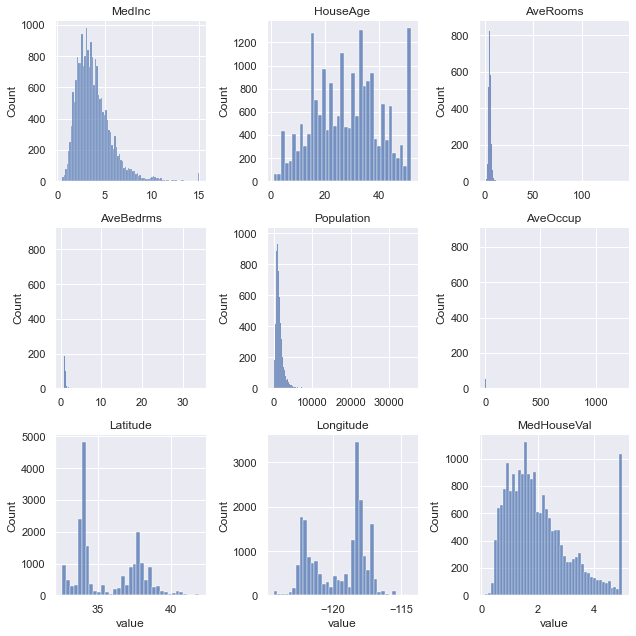

In [49]:
# build feature histograms to indificate distribution type and abnormal values
sns.set_theme()

melted = data.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

plt.show()

In [50]:
# describe basic features
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


In [51]:
# delete abnormal values from dataset
subset=data[features_of_interest]
z_scores=subset.apply(zscore)
z_scores

outliers=(np.abs(z_scores>3)).any(axis=1)
outliers_idx=data[outliers].index
outliers_idx

data_cleared=data.drop(outliers_idx)
data_cleared.shape

(20135, 9)

In [52]:
data_cleared[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20135.000000,20135.000000,20135.000000,20135.000000
mean,5.290628,1.068428,2.931787,1340.091631
std,1.270173,0.135177,0.885646,812.564686
min,0.846154,0.333333,0.750000,3.000000
25%,4.433389,1.004963,2.429156,788.000000
50%,5.212810,1.047859,2.817582,1158.000000
75%,6.017266,1.097856,3.280652,1692.000000
max,12.500000,2.514610,33.952941,4819.000000


Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

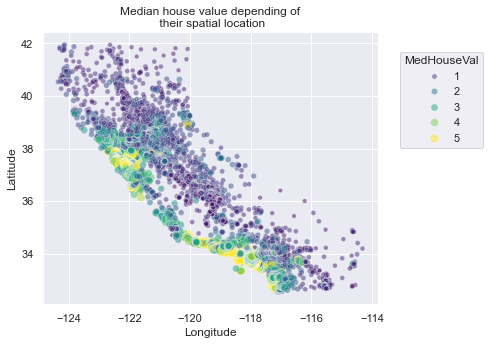

In [53]:
# build visualisation of house price depending on 'Longitude' and 'Latitude' 
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=california_housing.frame,
    x='Longitude',
    y='Latitude',
    size='MedHouseVal',
    hue='MedHouseVal',
    palette='viridis',
    alpha=0.5,
    ax=ax)

plt.legend(
    title='MedHouseVal',
    bbox_to_anchor=(1.05, 0.95),
    loc='upper left')

plt.title('Median house value depending of\n their spatial location')

# we see that 'Longitude' and 'Latitude' are important features and couldn't be excluded from a model

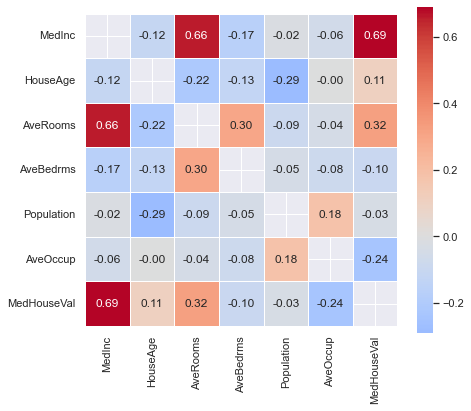

In [54]:
# build correlation matrix
columns_drop = ['Longitude', 'Latitude']
corr_mtx = data_cleared.drop(columns=columns_drop).corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(corr_mtx,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

plt.show()

In [55]:
# 'AveRooms' and 'MedInc' features have big positive correlation. But 'MedInc' has higher correlation with our target value, that's why couldn't be excluded
# Let's delete 'AveRooms' feature from our model
data_cleared=data_cleared.drop(columns=['AveRooms'])

data_cleared.head()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [56]:
# split on train and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    data_cleared.drop(columns=['MedHouseVal']),
    data_cleared['MedHouseVal'],
    test_size=0.2,
    random_state=42)

In [57]:
# perform data normalisation
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04,1.610800e+04
mean,-1.676224e-17,-1.248346e-16,1.764447e-17,-1.060874e-16,-3.793561e-17,-1.722100e-15,-8.151744e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.773858e+00,-2.240869e+00,-5.444216e+00,-1.644220e+00,-2.448193e+00,-1.450260e+00,-2.367900e+00
25%,-6.876112e-01,-7.974045e-01,-4.671025e-01,-6.811515e-01,-5.624555e-01,-7.992891e-01,-1.106958e+00
50%,-1.764550e-01,4.520411e-03,-1.525954e-01,-2.266418e-01,-1.286644e-01,-6.447421e-01,5.377489e-01
75%,4.568290e-01,6.460603e-01,2.172224e-01,4.354681e-01,3.899295e-01,9.709764e-01,7.869470e-01
max,5.862520e+00,1.848948e+00,1.070880e+01,4.271775e+00,3.487352e+01,2.951988e+00,2.511397e+00


In [58]:
# build a linear regression model
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
ymin, ymax = y_train.agg(['min', 'max']).values
y_pred=pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

7969     2.415358
17082    2.745517
5623     1.710072
16934    2.593909
7501     1.638296
dtype: float64

In [59]:
# model accuracy estimation
r_sq=model.score(X_train_scaled, y_train)
mae=mean_absolute_error(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


In [60]:
# polynomial regression 
# transform features to polynomial ones and estimate polinomial regression model
poly=PolynomialFeatures(2).set_output(transform='pandas')

Xtr=poly.fit_transform(X_train_scaled)
Xts=poly.transform(X_test_scaled)

model_upd=LinearRegression().fit(Xtr, y_train)
y_pred_upd=model_upd.predict(Xts)
y_pred_upd=pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd=model_upd.score(Xtr, y_train)
mae_upd=mean_absolute_error(y_test, y_pred_upd)
mape_upd=mean_absolute_percentage_error(y_test,y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.69 | MAE: 0.46 | MAPE: 0.26



# Conclusion
After clearing our dataset from abnormal values we have reached higher model accuracy in comparison with a model from a practical lesson. We reached 71% accuracy with simple linear regression model and 74% accuracy with polynomial regression model (against 69% and 73% correspondently).
We can notice that data preparation and cleanning are important steps which result in a model accuracy.